# Introduction:  
This notebook analyzes the progression of fitness and torque values in an evolutionary optimization process. It loads data from CSV files containing rewards across generations and the keyframe torque values of the best-performing individuals. The goal is to visualize how fitness improves over cycles and how torque values evolve over keyframes. The notebook is structured as follows:  
1. Loading fitness data to track reward progression across generations.  
2. Loading and processing torque keyframes of the best individuals.  
3. Visualizing trends in fitness progression and torque variations.  

These visualizations provide insights into how the optimization process affects both overall performance and individual keyframe adjustments.  

## 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

## 2. Functions to load data

### 2.1 Load Reward Data

Load fitness log data from a CSV file.

Parameters:
- file_path (str): Path to the CSV file.

Returns:
- pd.DataFrame: DataFrame containing generations, rewards, and cycle identifiers.

In [5]:
def load_reward_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, header=None, names=["Generation", "Reward"])
    df["Cycle"] = (df["Generation"] == 0).cumsum()  # Identify cycles
    return df

### 2.2 Load Data for Torque Progression

Loads the best individuals' keyframes from a CSV file.

Each row in the CSV represents one individual with its keyframes concatenated.
Since each keyframe consists of 7 values, the total number of values in a row 
must be divisible by 7. The function reshapes the row into a 2D NumPy array where 
each row corresponds to one keyframe.

It also clips out-of-bound values:
    - For indices 0-5 (action/torque values), the allowed range is [-1, 1].
    - For index 6 (duration), the allowed range is [0, 100].

Parameters:
- file_path (str): Path to the CSV file containing best individuals.

Returns:
- list of np.ndarray: A list where each element is a 2D NumPy array representing 
                        an individual's keyframes.

In [42]:
def load_best_individuals(file_path: str):
    individuals = []
    with open(file_path, "r") as file:
        reader = csv.reader(file)
        for row in reader:
            if not row or len(row) % 7 != 0:
                print(f"Skipping malformed row: {row}")
                continue  # Skip malformed rows

            values = np.array(row, dtype=float)
            keyframes = values.reshape(-1, 7)

            # Clip values to their respective ranges
            # keyframes[:, :6] = np.clip(keyframes[:, :6], -1, 1)   # Indices 0-5: [-1, 1]
            # keyframes[:, 6] = np.clip(keyframes[:, 6], 0, 100)    # Index 6: [0, 100]
            individuals.append(keyframes)
    
    return individuals


## 3. Functions to Plot Data

### 3.1 Plot Rewards Over Generations

Plot the reward progression over generations for different cycles.

Parameters:
- df (pd.DataFrame): DataFrame containing generations, rewards, and cycle identifiers.
- title (str): Title of the plot.
- legend (bool): Whether to show the legend.


In [43]:
def plot_fitness_progression(df: pd.DataFrame, title: str = "Fitness Progression Over Generations", legend: bool = True):
    plt.figure(figsize=(10, 6))
    cycles = df["Cycle"].unique()
    colors = plt.cm.jet(np.linspace(0, 1, len(cycles)))  # Generate distinct colors

    for cycle, color in zip(cycles, colors):
        cycle_data = df[df["Cycle"] == cycle]
        plt.plot(
            cycle_data["Generation"],
            cycle_data["Reward"],
            label=f"Cycle {cycle}",
            color=color
        )

    plt.xlabel("Generation")
    plt.ylabel("Reward")
    plt.title(title)

    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
        
    plt.grid()
    plt.tight_layout()  # Adjust layout to prevent clipping

    plt.show()

### 3.2 Plot Torque Progression

Plots torque values for multiple individuals.

For each individual, each keyframe is plotted as a line with the x-axis 
representing the keyframe component index (0 to 5) and the y-axis representing 
the corresponding torque value (first 6 values of a keyframe). The 7th value (duration) 
is omitted.

Parameters:
- individuals (list of np.ndarray): List of 2D arrays where each array represents 
                                        an individual's keyframes.



In [44]:
def plot_torques(individuals):
    plt.figure(figsize=(10, 6))
    
    colormap = plt.colormaps["viridis"]
    
    for idx, individual in enumerate(individuals):
        colors = colormap(np.linspace(0, 1, len(individual)))
        x = np.arange(6)
        
        for k, (y, color) in enumerate(zip(individual[:, :6], colors)):
            plt.plot(x, y, 'o-', alpha=0.7, markersize=3, linewidth=1, color=color, 
                     label=f"Ind {idx} KF {k}" if len(individual) < 10 else None)

    plt.xlabel("Keyframe Component Index")
    plt.ylabel("Torque Value")
    plt.title("Torque Variations in Generations")

    if sum(len(ind) for ind in individuals) < 20:
        plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=8)

    plt.grid()
    plt.tight_layout()
    plt.show()


## 4. Load Data and Plot

### 4.1.1 Rewards over Generations over Cycles

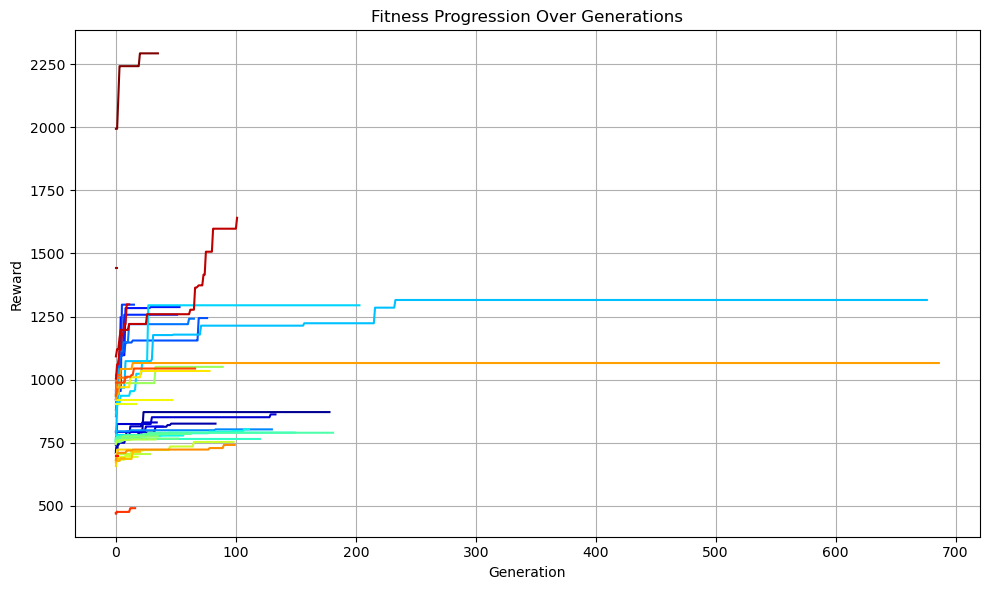

In [61]:
# Generate Fitness Progression Plot
FILE_PATH = "fitness_log.csv"

fitness_data = load_reward_data(FILE_PATH)
plot_fitness_progression(fitness_data, legend=False)


### 4.1.2 Average Fitness Progression  

I've come to realize that a more accurate representation of the algorithm's performance is how the average fitness of the population evolves over time. Tracking only the best individual can be misleading since an exceptional result might just be a fluke. By looking at the average fitness, I get a clearer picture of how the entire population is improving, rather than focusing on isolated successes. This helps in understanding whether the algorithm is consistently guiding the population toward better solutions or if progress is just driven by a few lucky individuals.

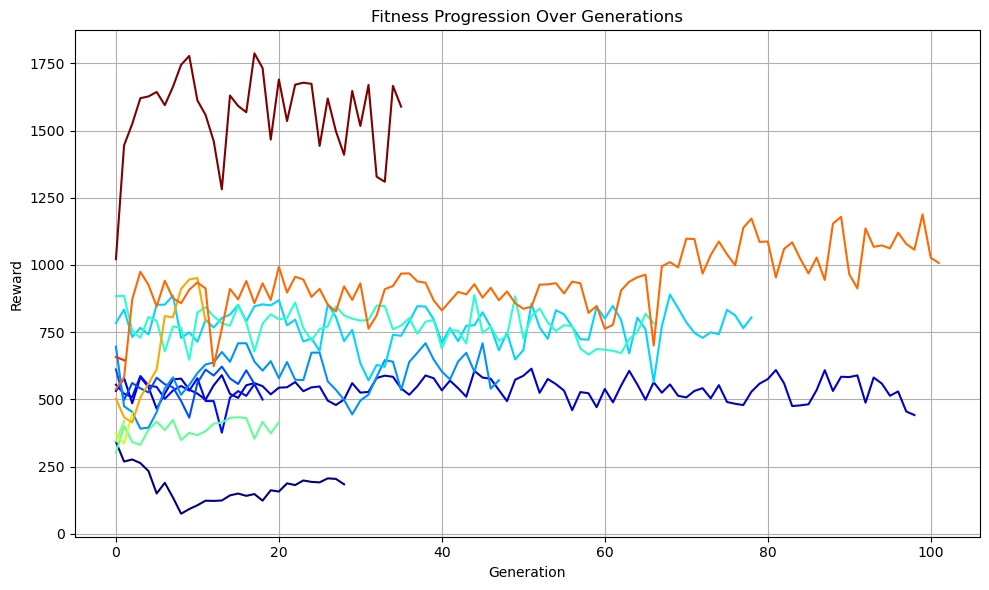

In [ ]:
# Generate Fitness Progression Plot
FILE_PATH = "average_fitness_log.csv"

fitness_data = load_reward_data(FILE_PATH)
plot_fitness_progression(fitness_data, title="Average Fitness Progression Over Generations",legend=False)


### 4.2 Torque Progression for Best Individuals

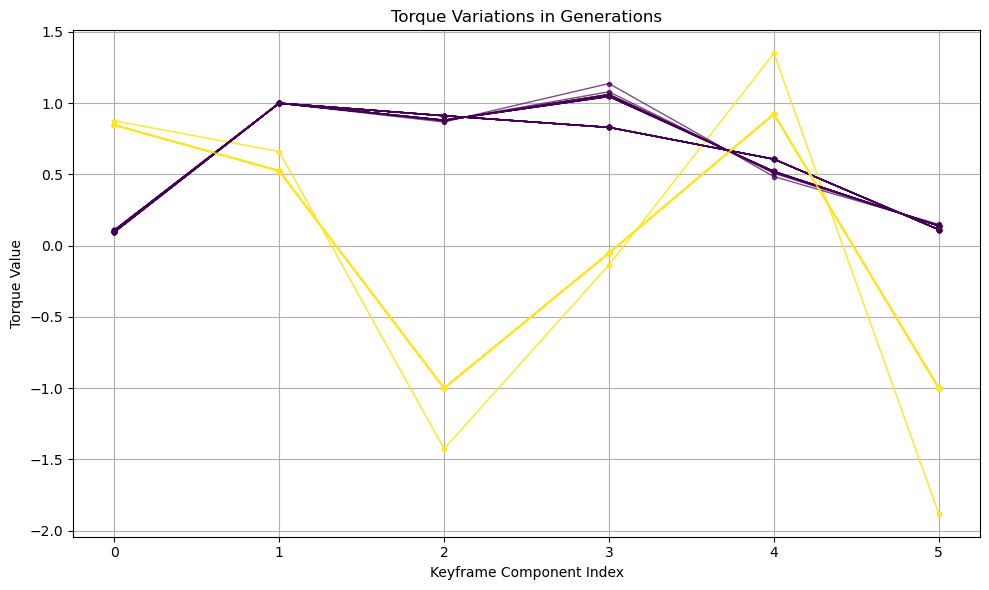

In [63]:
best_ind_file = "data/best_individual.csv"

individuals = load_best_individuals(best_ind_file)
if individuals:
    plot_torques(individuals)
else:
    print("No valid data found in CSV.")

# Conclusion  
The analysis highlights key trends in fitness improvement and torque evolution. The fitness progression plot illustrates how rewards change over generations and cycles, reflecting the effectiveness of the optimization process. The torque progression visualization reveals variations in keyframe torques, showing how individuals adjust their movement strategies over time. These insights can be used to refine evolutionary parameters and enhance performance in future iterations.